In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# scaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

# Models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Data

In [999]:
rumah123_df = pd.read_csv("../../data/rumah123_ready.csv")

### Splitting

In [1000]:
X = rumah123_df.drop(columns=['price'])
y = rumah123_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.index.size)
print(X_test.index.size)

15711
3928


In [1001]:
rumah123_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19639 entries, 0 to 19638
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          19639 non-null  int64 
 1   bedroom        19639 non-null  int64 
 2   bathroom       19639 non-null  int64 
 3   land_area      19639 non-null  int64 
 4   building_area  19639 non-null  int64 
 5   location       19639 non-null  object
dtypes: int64(5), object(1)
memory usage: 920.7+ KB


### Target Encoding

In [ ]:
# Inisialisasi dan fit TargetEncoder hanya pada train
encoder = TargetEncoder(cols=['location'])
encoder.fit(X_train, y_train)

# Transformasi train dan test
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

['../../models/mean_encoder.joblib']

### Feature Scalling

In [1004]:
# Inisiasi metode scalling
scalers = {
    'Standard': StandardScaler(),
    'MinMax':   MinMaxScaler(),
    'Robust':   RobustScaler(),
    'MaxAbs':   MaxAbsScaler()
}

In [1005]:
# evaluasi tiap scaler
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('reg', RandomForestRegressor(random_state=42))
    ])
    scores = cross_val_score(pipeline, X_train_encoded, y_train, cv=cv, scoring='r2', n_jobs=-1)
    results.append({
        'Scaler':    name,
        'Mean R2':   np.mean(scores),
        'Std Dev R2': np.std(scores)
    })

In [1006]:
# tampilkan hasil scalernya
scaler_results = pd.DataFrame(results).sort_values('Mean R2', ascending=False).reset_index(drop=True)
scaler_results

,Scaler,Mean R2,Std Dev R2
0,MaxAbs,0.670845,0.005970
1,Standard,0.670722,0.005733
2,Robust,0.670506,0.005731
3,MinMax,0.670372,0.006055


In [ ]:
# Normalisasi dengan MinMaxScaler
scaler_name = scaler_results.iloc[0]['Scaler']
scaler = scalers[scaler_name]
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

['../../models/scaler.joblib']

### Modeling

In [1008]:
# Inisialisasi model
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

In [1009]:
# Evaluasi model
def model_selection_regression(X_train, X_test, y_train, y_test):
    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        results.append({
            'Model': name,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        })

    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='R²', ascending=False)

In [1010]:
results = model_selection_regression(X_train_scaled, X_test_scaled, y_train, y_test)
results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 15711, number of used features: 5
[LightGBM] [Info] Start training from score 1133.673541


,Model,MAE,MSE,RMSE,R²
2,XGBoost,209.497348,81058.391941,284.707555,0.681159
4,CatBoost,214.640614,82585.007092,287.376073,0.675154
0,Random Forest,207.340054,84391.073628,290.501418,0.668050
3,LightGBM,217.706981,84712.466917,291.054062,0.666786
1,Extra Trees,212.073078,91387.251366,302.303244,0.640531


In [1011]:
def plot_best_model_reg(X_train, X_test, y_train, y_test):
    
    # Ambil model terbaik
    best_model_name = results.iloc[0]['Model']
    best_model = models[best_model_name]
    
    # Fit dan prediksi
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Aktual')
    plt.ylabel('Prediksi')
    plt.title(f'Perbandingan Aktual vs Prediksi (Model Terbaik: {best_model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

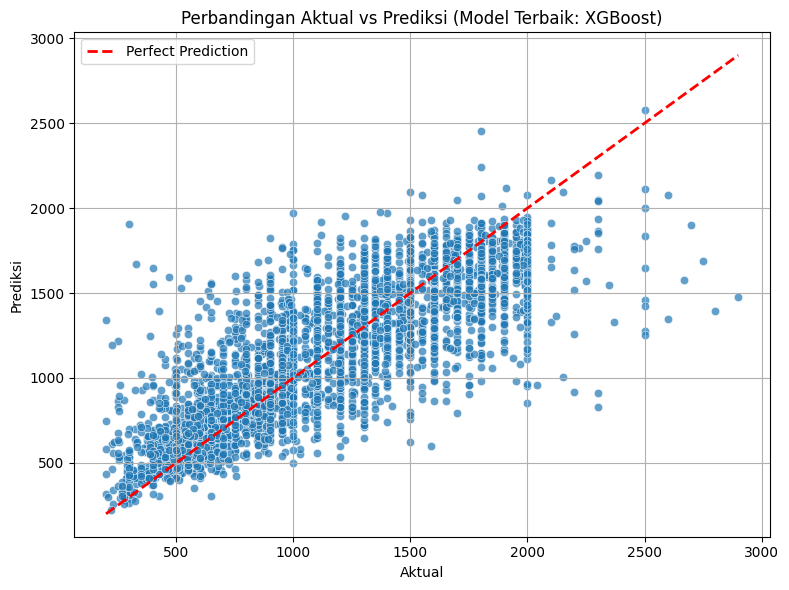

In [1012]:
plot_best_model_reg(X_train_scaled, X_test_scaled, y_train, y_test)